

Paper: https://arxiv.org/pdf/2110.00530.pdf

## 0.0 Notebook Setup

In [1]:
!pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 3.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics, preprocessing
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression

# import wandb
import random

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio, demographic_parity_difference, equalized_odds_difference
from fairlearn.reductions import DemographicParity


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
'''
NOTES 
  1. Attributes table
  2. Feature Selection
  3. Correlation 
  4. DPR and EO
'''

'\nNOTES \n  1. Attributes table\n  2. Feature Selection\n  3. Correlation \n  4. DPR and EO\n'

In [4]:
def dpd(prediction, true, sensitive_features):
  return demographic_parity_difference(true,prediction, sensitive_features=sensitive_features)


def eod(prediction, true, sensitive_features):
  return equalized_odds_difference(true,prediction, sensitive_features=sensitive_features)

## 1.0 Compas Dataset

In [5]:
compas_link ='https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
compas_data = pd.read_csv(compas_link, on_bad_lines='skip')

### 1.1 Data Cleaning and Feature Selection

COMPAS Recid Dataset.
- 7,124 --> 6,172 when cleaned 
- 51 attributes
  - 31 Categorical
  - 6 Binary 
  - 14 Numerical 
- Balanced target class (1:1.20 ratio for +:-) 
- Target: Two year recidivism.



In [6]:
# Check nulls 
compas_data.isna().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

In [ ]:
# Check number of unique 
compas_data.nunique()

id                         7214
name                       7158
first                      2800
last                       3950
compas_screening_date       690
sex                           2
dob                        5452
age                          65
age_cat                       3
race                          6
juv_fel_count                11
decile_score                 10
juv_misd_count               10
juv_other_count              10
priors_count                 37
days_b_screening_arrest     423
c_jail_in                  6907
c_jail_out                 6880
c_case_number              7192
c_offense_date              927
c_arrest_date               580
c_days_from_compas          499
c_charge_degree               2
c_charge_desc               437
is_recid                      2
r_case_number              3471
r_charge_degree              10
r_days_from_arrest          201
r_offense_date             1075
r_charge_desc               340
r_jail_in                   972
r_jail_o

In [7]:
# compas_data.nunique()

# Delete: id, name, first, last, dob, age_cat, compas_screening_date, 
  # Delete: days_b_screening_arrest,c_charge_desc, c_jail_in, c_jail_out, c_case_number, c_offense_date, c_arrest_date, c_days_from_compas 
  # recid info (bias, lots of unlls):  is_recid, r_case_number, r_charge_degree, r_days_from_arrest, r_offense_date, r_charge_desc, r_jail_in, r_jail_out, violent_recid
  # Delete:  is_violent_recid, vr_case_number, vr_charge_degree, vr_offense_date, vr_charge_desc, start, end, event
  # Delete (one unique value): type_of_assessment
  # COMPAS outputs: v_type_of_assessment, v_decile_score, v_score_text, v_screening_date , decile_score  
  # Repeats: decile_score.1, screening_date, priors_count.1 
  # Pro-Publical Score: score_text
#         
# Maybe: in_custody, out_custody
# Keep:  
    # One-Hot Encode: sex, c_charge_degree
    # Label Encode: 
    # Leave: age , juv_fel_count, decile_score, juv_misd_count, juv_other_count, priors_count

    # Make binary, single column: race
    # Target: two_year_recid 

def load_compas(target_name = 'two_year_recid', sensitive_name = 'race'): 

  # Load Data 
  compas_link ='https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
  compas_data = pd.read_csv(compas_link, on_bad_lines='skip')

  # Trim Undesired Columns 
  compas_data = compas_data[['age' , 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count','sex','c_charge_degree','race','two_year_recid']]
  compas_to_oh = ['sex','c_charge_degree']

  # Fix Race 
  compas_data.loc[compas_data.race != 'Caucasian', 'race'] = 1
  compas_data.loc[compas_data.race == 'Caucasian', 'race'] = 0
  compas_data.race = compas_data.race.astype(int)

  # Get Target and Sensitive 
  target = compas_data[target_name]
  sensitive = compas_data[[sensitive_name]]

  # Remove target 
  #compas_data = compas_data[['age' , 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count','sex','c_charge_degree','race']]
  
  # One-hot-encode sex & c_charge_degree
  compas_data = pd.get_dummies(compas_data, columns = compas_to_oh)

  # Returns x, y, sensitive (with sensitive still included in x )
  return compas_data, sensitive

In [8]:
compas, sensitive = load_compas()
compas.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race,two_year_recid,sex_Female,sex_Male,c_charge_degree_F,c_charge_degree_M
0,69,0,0,0,0,1,0,0,1,1,0
1,34,0,0,0,0,1,1,0,1,1,0
2,24,0,0,1,4,1,1,0,1,1,0
3,23,0,1,0,1,1,0,0,1,1,0
4,43,0,0,0,2,1,0,0,1,1,0


### 1.2 Feature Correlation

In [9]:
# Load Data 
compas_link ='https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
compas_data = pd.read_csv(compas_link, on_bad_lines='skip')

# Trim Undesired Columns 
compas_data = compas_data[['age' , 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count','sex','c_charge_degree','race','two_year_recid']]

# Fix Race 
compas_data.loc[compas_data.race != 'Caucasian', 'race'] = 1
compas_data.loc[compas_data.race == 'Caucasian', 'race'] = 0

compas_data.race = compas_data.race.astype(int)

compas_data.loc[compas_data.c_charge_degree != 'F', 'c_charge_degree'] = 0
compas_data.loc[compas_data.c_charge_degree == 'F', 'c_charge_degree'] = 1

compas_data.loc[compas_data.sex != 'Male', 'sex'] = 0
compas_data.loc[compas_data.sex == 'Male', 'sex'] = 1

In [17]:
race_df = compas_data[['race','two_year_recid']]
race_df.corr()

,race,two_year_recid
race,1.000000,0.082268
two_year_recid,0.082268,1.000000


<ipython-input-10-3cc4b1129909>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  compas_corr = compas_data.corr()


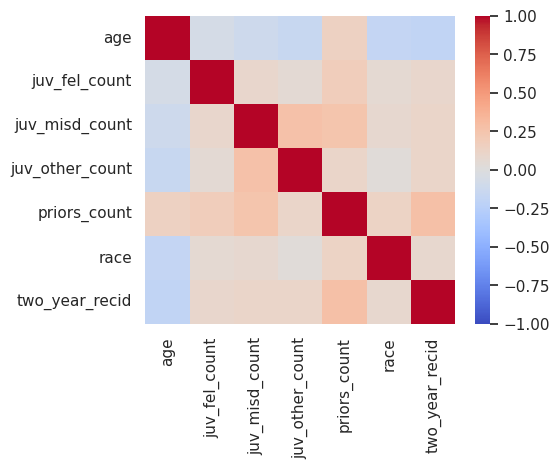

In [10]:
compas_corr = compas_data.corr()
sns.set(rc={'figure.figsize':(5,4)})
sns.heatmap(compas_corr,cmap="coolwarm",vmin=-1,vmax=1)
plt.show()

In [ ]:
# Load data 
compas_link ='https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
compas_data = pd.read_csv(compas_link, on_bad_lines='skip')

# Pick columns with latent recidivism information
compas_data = compas_data[['race','two_year_recid','is_recid', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out']]

# Turn race variable into binary 
compas_data.loc[compas_data.race != 'Caucasian', 'race'] = 1
compas_data.loc[compas_data.race == 'Caucasian', 'race'] = 0
compas_data['race'] = compas_data['race'].astype(int)

# Set mixed-type data to 1 if it is non-null and 0 if it is null
for col in ['r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out']:
  compas_data.loc[~compas_data[col].isna(), col] = 1
  compas_data.loc[compas_data[col].isna(), col] = 0
  compas_data[col] = compas_data[col].astype(int)

compas_data['is_recid'] = compas_data['is_recid'].astype(int)


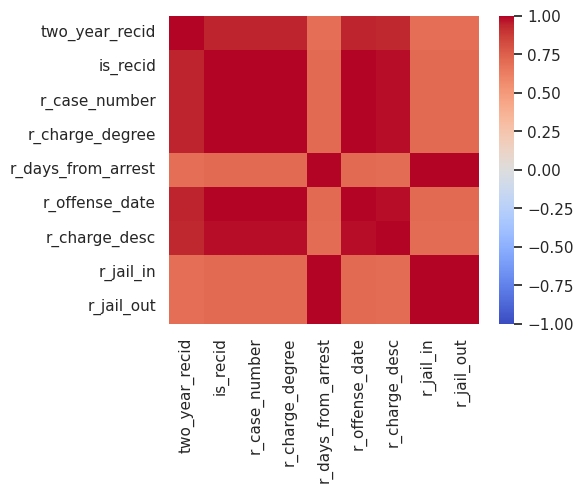

In [ ]:
compas_corr = compas_data.corr()
sns.set(rc={'figure.figsize':(5,4)})
sns.heatmap(compas_corr,cmap="coolwarm",vmin=-1,vmax=1)
plt.show()

In [ ]:
# Caucausion is zero - non-Caucasion convicts tend to be younger. 
compas_data.groupby('race').mean()['age']

KeyError: ignored

In [ ]:
sns.set_theme()
sns.histplot(compas_data.loc[compas_data.race==0].age,label = 'Caucasian',alpha=0.8)
sns.histplot(compas_data.loc[compas_data.race==1].age,label= 'Non-Caucasian',alpha=0.4)
plt.legend()
plt.show()

### 1.3 DPR and EO Metrics

In [ ]:
compas_dpd = dpd(compas_data.two_year_recid, compas_data.two_year_recid, compas_data.race)
compas_dpd.round(3)

0.274

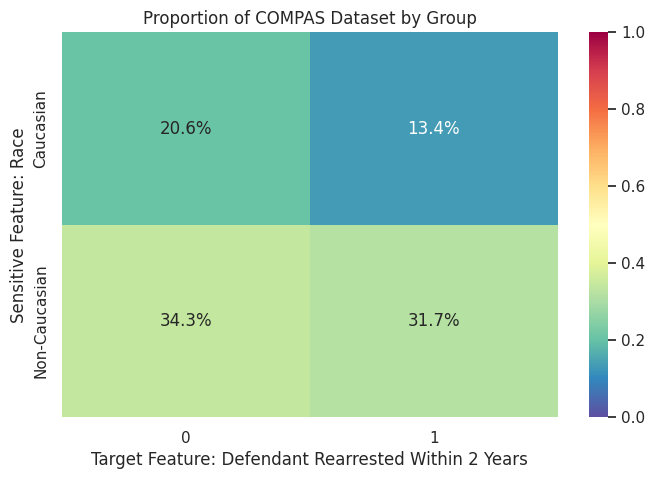

In [ ]:
compas_data = pd.read_csv(compas_link, on_bad_lines='skip')
compas_data.loc[compas_data.race != 'Caucasian', 'race'] = 'Non-Caucasian'
compas_data.loc[compas_data.race == 'Caucasian', 'race'] = 'Caucasian'

compas_cm_df = compas_data.groupby(['race','two_year_recid']).count()['age']
compas_cm_df = pd.DataFrame(compas_cm_df).reset_index()
compas_cm_df = compas_cm_df.pivot(index='race',columns='two_year_recid',values='age')

compas_cm_df = compas_cm_df / compas_cm_df.sum().sum()
compas_cm_df = compas_cm_df.round(3)

sns.set(rc={'figure.figsize':(8,5)})
sns.heatmap(compas_cm_df,vmin=0,vmax=1,annot=True,fmt=".1%",cmap="Spectral_r")
plt.xlabel("Target Feature: Defendant Rearrested Within 2 Years")
plt.ylabel("Sensitive Feature: Race")
plt.title("Proportion of COMPAS Dataset by Group")
plt.show()

In [ ]:
compas_data.groupby(['two_year_recid']).count()['age'] / len(compas_data)

compas_data.groupby(['race']).count()['age']/ len(compas_data)

race
Caucasian        0.340172
Non-Caucasian    0.659828
Name: age, dtype: float64

### 1.4 Feature Importance

In [ ]:
df_compas,_ = load_compas()

# Model for target variable
X_t = df_compas.drop(['two_year_recid'],axis=1)
y_t = df_compas['two_year_recid']

# Model for sensitive variables
X_s = df_compas.drop(['race'],axis=1)
y_s = df_compas['race']

In [ ]:
# Model for target variable
compas_lr_m_t = LogisticRegression(max_iter=10000)
compas_result_t = compas_lr_m_t.fit(X_t,y_t)

In [ ]:
# Model for sensitive variables
compas_lr_m_s = LogisticRegression(max_iter=10000)
compas_result_s = compas_lr_m_s.fit(X_s,y_s)

In [ ]:
compas_t_fi = pd.DataFrame(compas_result_t.coef_[0],X_t.columns).reset_index()
compas_t_fi.columns = ['feature','lr_beta']
compas_t_fi = compas_t_fi.sort_values(by='lr_beta',ascending=False)

print("----------------------------------------------------")
print("-------------------Positive Impact-------------------")
print("----------------------------------------------------")
print(compas_t_fi.head(5))
print("----------------------------------------------------")
print("-------------------Negative Impact------------------")
print("----------------------------------------------------")
print(compas_t_fi.tail(5))
print("----------------------------------------------------")
print("-------------------Overall Impact------------------")
print("----------------------------------------------------")
compas_t_fi['abs_lr_beta'] = compas_t_fi.lr_beta.abs()
compas_t_fi = compas_t_fi.sort_values(by='abs_lr_beta',ascending=False)
print(compas_t_fi.head(7)[['feature','lr_beta']])

----------------------------------------------------
-------------------Positive Impact-------------------
----------------------------------------------------
             feature   lr_beta
7           sex_Male  0.318030
8  c_charge_degree_F  0.262782
3    juv_other_count  0.187993
1      juv_fel_count  0.170271
4       priors_count  0.148744
----------------------------------------------------
-------------------Negative Impact------------------
----------------------------------------------------
             feature   lr_beta
9  c_charge_degree_M  0.085447
6         sex_Female  0.030199
2     juv_misd_count  0.024023
5               race -0.016670
0                age -0.044783
----------------------------------------------------
-------------------Overall Impact------------------
----------------------------------------------------
             feature   lr_beta
7           sex_Male  0.318030
8  c_charge_degree_F  0.262782
3    juv_other_count  0.187993
1      juv_fel_count  0.170

In [ ]:
compas_s_fi = pd.DataFrame(compas_result_s.coef_[0],X_s.columns).reset_index()
compas_s_fi.columns = ['feature','lr_beta']
compas_s_fi = compas_s_fi.sort_values(by='lr_beta',ascending=False)

print("----------------------------------------------------")
print("-------------------Positive Impact-------------------")
print("----------------------------------------------------")
print(compas_s_fi.head(5))
print("----------------------------------------------------")
print("-------------------Negative Impact------------------")
print("----------------------------------------------------")
print(compas_s_fi.tail(5))
print("----------------------------------------------------")
print("-------------------Overall Impact------------------")
print("----------------------------------------------------")
compas_s_fi['abs_lr_beta'] = compas_s_fi.lr_beta.abs()
compas_s_fi = compas_s_fi.sort_values(by='abs_lr_beta',ascending=False)
print(compas_s_fi.head(5)[['feature','lr_beta']])

----------------------------------------------------
-------------------Positive Impact-------------------
----------------------------------------------------
             feature   lr_beta
1      juv_fel_count  0.240509
2     juv_misd_count  0.193712
7           sex_Male  0.142828
4       priors_count  0.071230
8  c_charge_degree_F  0.066697
----------------------------------------------------
-------------------Negative Impact------------------
----------------------------------------------------
             feature   lr_beta
5     two_year_recid -0.017032
0                age -0.034133
9  c_charge_degree_M -0.043932
6         sex_Female -0.120063
3    juv_other_count -0.149564
----------------------------------------------------
-------------------Overall Impact------------------
----------------------------------------------------
           feature   lr_beta
1    juv_fel_count  0.240509
2   juv_misd_count  0.193712
3  juv_other_count -0.149564
7         sex_Male  0.142828
6     

## 2.0 Adult Dataset

https://archive.ics.uci.edu/ml/datasets/adult


In [ ]:
# Most work classes belong to private 
# Class imbalance suggests that there is likely not much signal 
adult_data = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")

#adult_data.groupby('work_class').count()['age'] / len(adult_data)

In [ ]:
len(adult_data)

32561

### 2.1 Data Cleaning and Feature Selection


- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.


In [ ]:
# No null values 
adult_data.isna().sum()

age               0
work_class        0
fnlwgt            0
education         0
education_num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [ ]:
# Check number of unique 
adult_data.nunique()

age                  73
work_class            9
fnlwgt            21648
education            16
education_num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital_gain        119
capital_loss         92
hours_per_week       94
native_country       42
income                2
dtype: int64

In [19]:
adult_data = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")

# Delete: 
  # fnlwgt as advised by paper and previous literature 
  # education (captured in education number)
  # relationship remove because it is a proxy for gender (e.g. husband, wife)
  # native_country mostly united states or null but a ton of other values (one-hot-encoding would explode feature set)
  # work_class - 70% private, lots of options, likely not good signal 
# Keep: 
  # Leave as-is: 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'
  # One hot encode: ['work_class','marital-status', 'occupation','race','sex']

# Create Binaries: 
  # Race 
  # Sex

# Target: 
  # income

def load_adult(target_name = 'income', sensitive_name = 'sex_binary'): 

  # Load Data 
  adult_data = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")

  # Create binary for race 
  adult_data.loc[adult_data.race != ' White', 'race_binary'] = 1
  adult_data.loc[adult_data.race == ' White', 'race_binary'] = 0
  adult_data.race = adult_data.race_binary.astype(int)

  # Create binary for sex 
  adult_data.loc[adult_data.sex != ' Male', 'sex_binary'] = 1
  adult_data.loc[adult_data.sex == ' Male', 'sex_binary'] = 0
  adult_data.sex = adult_data.sex_binary.astype(int)

  # Create binary for income 
  adult_data.loc[adult_data.income != ' >50K', 'income'] = 0
  adult_data.loc[adult_data.income == ' >50K', 'income'] = 1
  adult_data.income = adult_data.income.astype(int)

  adult_data = adult_data[['marital-status','occupation','race_binary','sex_binary','education_num', 'capital_gain', 'capital_loss', 'hours_per_week','income']]

  # One hot encode 
  adult_to_oh = ['marital-status', 'occupation']
  adult_data = pd.get_dummies(adult_data,columns=adult_to_oh)
  
  sensitive = adult_data[sensitive_name]
  
  return adult_data, sensitive

In [ ]:
def get_balanced_adult():
  # Load Data 
  df = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")

  df_pos = df.loc[df.income==' >50K']
  df_neg = df.loc[df.income==' <=50K']
  df_neg_sample = df_neg.sample(len(df_pos),random_state=15)
  df_new = pd.concat([df_pos,df_neg_sample],axis=0)
  return df_new

def load_adult_balanced(target_name = 'income', sensitive_name = 'sex_binary'):

  # Load Data 
  adult_data = get_balanced_adult()

  # Create binary for race 
  adult_data.loc[adult_data.race != ' White', 'race_binary'] = 1
  adult_data.loc[adult_data.race == ' White', 'race_binary'] = 0
  adult_data.race = adult_data.race_binary.astype(int)

  # Create binary for sex 
  adult_data.loc[adult_data.sex != ' Male', 'sex_binary'] = 1
  adult_data.loc[adult_data.sex == ' Male', 'sex_binary'] = 0
  adult_data.sex = adult_data.sex_binary.astype(int)

  # Create binary for income 
  adult_data.loc[adult_data.income != ' >50K', 'income'] = 0
  adult_data.loc[adult_data.income == ' >50K', 'income'] = 1
  adult_data.income = adult_data.income.astype(int)

  adult_data = adult_data[['marital-status','occupation','race_binary','sex_binary','education_num', 'capital_gain', 'capital_loss', 'hours_per_week','income']]

  # One hot encode 
  adult_to_oh = ['marital-status', 'occupation']
  adult_data = pd.get_dummies(adult_data,columns=adult_to_oh)
  
  sensitive = adult_data[sensitive_name]
  
  return adult_data, df_new, sensitive



### 2.2 Correlations

In [ ]:
# Load Data 
adult_data = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")
adult_data_master = adult_data.copy()

# Create binary for race 
adult_data.loc[adult_data.race != ' White', 'race_binary'] = 1
adult_data.loc[adult_data.race == ' White', 'race_binary'] = 0
adult_data.race_binary = adult_data.race_binary.astype(int)

# Create binary for sex 
adult_data.loc[adult_data.sex != ' Male', 'sex_binary'] = 1
adult_data.loc[adult_data.sex == ' Male', 'sex_binary'] = 0
adult_data.sex_binary = adult_data.sex_binary.astype(int)

# Create binary for income 
adult_data.loc[adult_data.income != ' >50K', 'income'] = 0
adult_data.loc[adult_data.income == ' >50K', 'income'] = 1
adult_data.income = adult_data.income.astype(int)

adult_data = adult_data[['marital-status', 'occupation','race_binary','sex_binary','education_num', 'capital_gain', 'capital_loss', 'hours_per_week','income']]


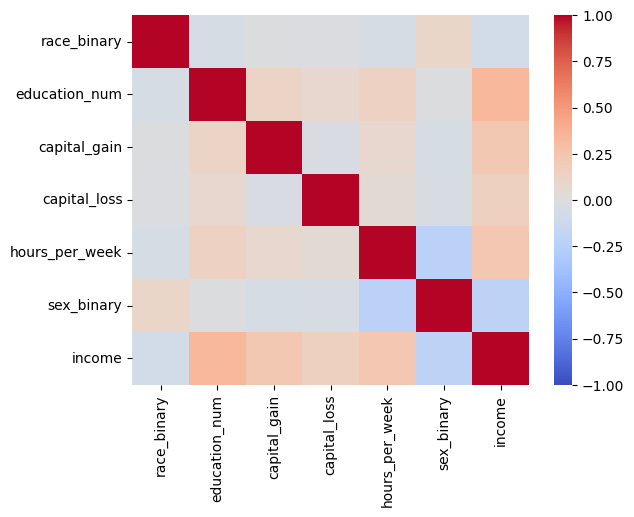

In [ ]:
adult_data = adult_data[['marital-status', 'occupation','race_binary','education_num', 'capital_gain', 'capital_loss', 'hours_per_week','sex_binary','income']]
adult_corr = adult_data.corr()
sns.heatmap(adult_corr,cmap="coolwarm",vmin=-1,vmax=1)
plt.show()

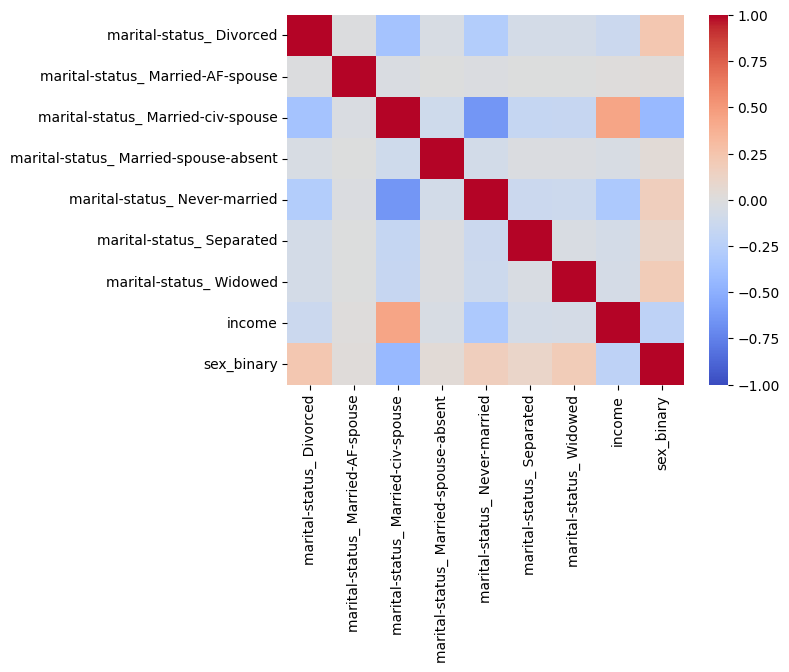

In [ ]:
col = 'marital-status' #, 'occupation','sex'
adult_data2 = pd.DataFrame(adult_data_master[col])
adult_data2 = pd.get_dummies(adult_data2,columns=[col])
adult_data2['income'] = adult_data.income
adult_data2['sex_binary'] = adult_data.sex_binary
adult_corr2 = adult_data2.corr()
sns.heatmap(adult_corr2,cmap="coolwarm",vmin=-1,vmax=1)
plt.show()

In [ ]:
# Select marital-status_ Married-civ-spouse, marital-status_ Never-married , marital-status_ Divorced  
adult_data2.sum() / adult_data2.count()

marital-status_ Divorced                 0.136452
marital-status_ Married-AF-spouse        0.000706
marital-status_ Married-civ-spouse       0.459937
marital-status_ Married-spouse-absent    0.012837
marital-status_ Never-married            0.328092
marital-status_ Separated                0.031479
marital-status_ Widowed                  0.030497
income                                   0.240810
sex_binary                               0.330795
dtype: float64

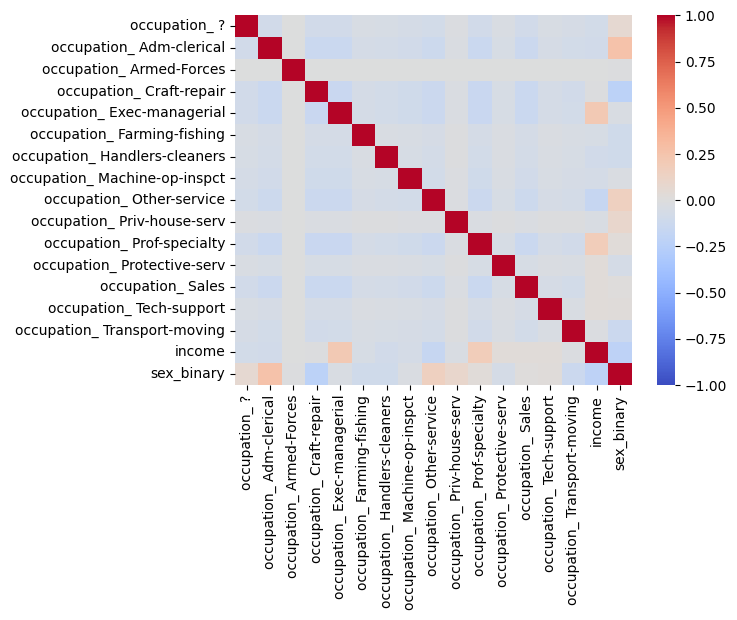

In [ ]:
col = 'occupation'
adult_data3 = pd.DataFrame(adult_data_master[col])
adult_data3 = pd.get_dummies(adult_data3,columns=[col])
adult_data3['income'] = adult_data.income
adult_data3['sex_binary'] = adult_data.sex_binary
adult_corr3 = adult_data3.corr()
sns.heatmap(adult_corr3,cmap="coolwarm",vmin=-1,vmax=1)
plt.show()

In [ ]:
# Select occupation_ Prof-specialty and occupation_ Exec-managerial  
adult_data3.sum() / adult_data3.count()

occupation_ ?                    0.056601
occupation_ Adm-clerical         0.115783
occupation_ Armed-Forces         0.000276
occupation_ Craft-repair         0.125887
occupation_ Exec-managerial      0.124873
occupation_ Farming-fishing      0.030527
occupation_ Handlers-cleaners    0.042075
occupation_ Machine-op-inspct    0.061485
occupation_ Other-service        0.101195
occupation_ Priv-house-serv      0.004576
occupation_ Prof-specialty       0.127146
occupation_ Protective-serv      0.019932
occupation_ Sales                0.112097
occupation_ Tech-support         0.028500
occupation_ Transport-moving     0.049046
income                           0.240810
sex_binary                       0.330795
dtype: float64

### 2.3 DPR and EO Metrics

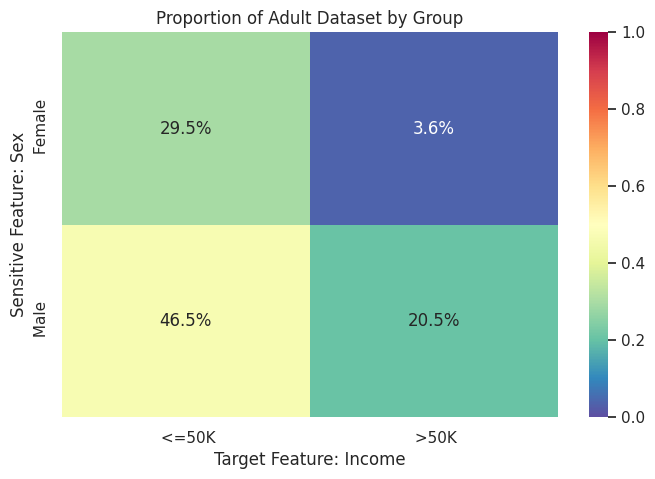

In [ ]:
adult_data = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")

adult_cm_df = adult_data.groupby(['sex','income']).count()['age']
adult_cm_df = pd.DataFrame(adult_cm_df).reset_index()
adult_cm_df = adult_cm_df.pivot(index='sex',columns='income',values='age')

adult_cm_df = adult_cm_df / adult_cm_df.sum().sum()
adult_cm_df = adult_cm_df.round(3)

sns.set(rc={'figure.figsize':(8,5)})
sns.heatmap(adult_cm_df,vmin=0,vmax=1,annot=True,fmt=".1%",cmap="Spectral_r")
plt.xlabel("Target Feature: Income")
plt.ylabel("Sensitive Feature: Sex")
plt.title("Proportion of Adult Dataset by Group")

plt.show()

In [ ]:
adult_data = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")

# Create binary for sex 
adult_data.loc[adult_data.sex != ' Male', 'sex_binary'] = 1
adult_data.loc[adult_data.sex == ' Male', 'sex_binary'] = 0
adult_data.sex_binary = adult_data.sex_binary.astype(int)

# # Create binary for income 
adult_data.loc[adult_data.income != ' >50K', 'income'] = 0
adult_data.loc[adult_data.income == ' >50K', 'income'] = 1


In [ ]:
adult_dpd = dpd(adult_data.income, adult_data.income, adult_data.sex_binary)
adult_dpd.round(3)

0.196

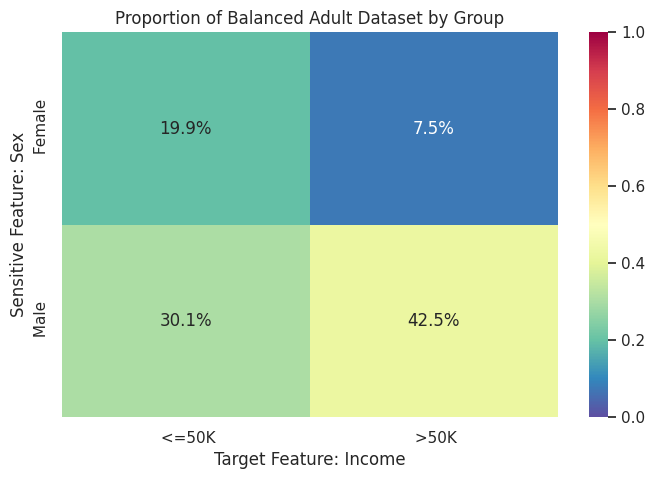

In [ ]:
adult_balanced = get_balanced_adult()

adultb_cm_df = adult_balanced.groupby(['sex','income']).count()['age']
adultb_cm_df = pd.DataFrame(adultb_cm_df).reset_index()
adultb_cm_df = adultb_cm_df.pivot(index='sex',columns='income',values='age')

adultb_cm_df = adultb_cm_df / adultb_cm_df.sum().sum()
adultb_cm_df = adultb_cm_df.round(3)

sns.set(rc={'figure.figsize':(8,5)})
sns.heatmap(adultb_cm_df,vmin=0,vmax=1,annot=True,fmt=".1%",cmap="Spectral_r")
plt.xlabel("Target Feature: Income")
plt.ylabel("Sensitive Feature: Sex")
plt.title("Proportion of Balanced Adult Dataset by Group")

plt.show()

In [ ]:

# Create binary for sex 
adult_balanced.loc[adult_balanced.sex != ' Male', 'sex_binary'] = 1
adult_balanced.loc[adult_balanced.sex == ' Male', 'sex_binary'] = 0
adult_balanced.sex_binary = adult_balanced.sex_binary.astype(int)

# # Create binary for income 
adult_balanced.loc[adult_balanced.income != ' >50K', 'income'] = 0
adult_balanced.loc[adult_balanced.income == ' >50K', 'income'] = 1


In [ ]:
adult_dpd = dpd(adult_balanced.income, adult_balanced.income, adult_balanced.sex_binary)
adult_dpd.round(3)

0.31

### 2.4 Feature Importance

In [ ]:
df_adult,_ = load_adult()

# Model for target variable
X_t = df_adult.drop(['income'],axis=1)
y_t = df_adult['income']

# Model for sensitive variables
X_s = df_adult.drop(['sex_binary'],axis=1)
y_s = df_adult['sex_binary']

In [ ]:
# Model for target variable
adult_lr_m_t = LogisticRegression(max_iter=10000)
adult_result_t = adult_lr_m_t.fit(X_t,y_t)

In [ ]:
# Model for sensitive variables
adult_lr_m_s = LogisticRegression(max_iter=10000)
adult_result_s = adult_lr_m_s.fit(X_s,y_s)

In [ ]:
adult_t_fi = pd.DataFrame(adult_result_t.coef_[0],X_t.columns).reset_index()
adult_t_fi.columns = ['feature','lr_beta']
adult_t_fi = adult_t_fi.sort_values(by='lr_beta',ascending=False)

print("----------------------------------------------------")
print("-------------------Positive Impact-------------------")
print("----------------------------------------------------")
print(adult_t_fi.head(5))
print("----------------------------------------------------")
print("-------------------Negative Impact------------------")
print("----------------------------------------------------")
print(adult_t_fi.tail(5))
print("----------------------------------------------------")
print("-------------------Overall Impact------------------")
print("----------------------------------------------------")
adult_t_fi['abs_lr_beta'] = adult_t_fi.lr_beta.abs()
adult_t_fi = adult_t_fi.sort_values(by='abs_lr_beta',ascending=False)
print(adult_t_fi.head(7)[['feature','lr_beta']])

----------------------------------------------------
-------------------Positive Impact-------------------
----------------------------------------------------
                               feature   lr_beta
8   marital-status_ Married-civ-spouse  0.770972
17         occupation_ Exec-managerial  0.633395
26            occupation_ Tech-support  0.538538
2                        education_num  0.278201
24         occupation_ Protective-serv  0.232709
----------------------------------------------------
-------------------Negative Impact------------------
----------------------------------------------------
                          feature   lr_beta
19  occupation_ Handlers-cleaners -1.214543
21      occupation_ Other-service -1.296385
18    occupation_ Farming-fishing -1.390785
6        marital-status_ Divorced -1.442172
10  marital-status_ Never-married -2.063314
----------------------------------------------------
-------------------Overall Impact------------------
------------------

In [ ]:
adult_s_fi = pd.DataFrame(adult_result_s.coef_[0],X_s.columns).reset_index()
adult_s_fi.columns = ['feature','lr_beta']
adult_s_fi = adult_s_fi.sort_values(by='lr_beta',ascending=False)

print("----------------------------------------------------")
print("-------------------Positive Impact-------------------")
print("----------------------------------------------------")
print(adult_t_fi.head(5))
print("----------------------------------------------------")
print("-------------------Negative Impact------------------")
print("----------------------------------------------------")
print(adult_t_fi.tail(5))
print("----------------------------------------------------")
print("-------------------Overall Impact------------------")
print("----------------------------------------------------")
adult_s_fi['abs_lr_beta'] = adult_s_fi.lr_beta.abs()
adult_s_fi = adult_s_fi.sort_values(by='abs_lr_beta',ascending=False)
print(adult_s_fi.head(5)[['feature','lr_beta']])

----------------------------------------------------
-------------------Positive Impact-------------------
----------------------------------------------------
                          feature   lr_beta  abs_lr_beta
10  marital-status_ Never-married -2.063314     2.063314
6        marital-status_ Divorced -1.442172     1.442172
18    occupation_ Farming-fishing -1.390785     1.390785
21      occupation_ Other-service -1.296385     1.296385
19  occupation_ Handlers-cleaners -1.214543     1.214543
----------------------------------------------------
-------------------Negative Impact------------------
----------------------------------------------------
                       feature   lr_beta  abs_lr_beta
23  occupation_ Prof-specialty  0.074601     0.074601
5               hours_per_week  0.025509     0.025509
15    occupation_ Armed-Forces -0.011713     0.011713
4                 capital_loss  0.000672     0.000672
3                 capital_gain  0.000322     0.000322
---------------

## 3.0 Dutch Census

https://github.com/tailequy/fairness_dataset/tree/main/experiments/data


In [5]:
dutch_link = 'https://github.com/tailequy/fairness_dataset/raw/main/experiments/data/dutch.csv'
dutch_data = pd.read_csv(dutch_link, on_bad_lines='skip')

In [ ]:
len(dutch_data)

60420

In [10]:
dutch_data.head()

,sex,age,household_position,household_size,prev_residence_place,citizenship,country_birth,edu_level,economic_status,cur_eco_activity,marital_status,occupation
0,male,6,1131,112,1,1,1,5,111,135,1,1
1,female,10,1122,113,1,1,1,2,111,122,2,0
2,male,8,1122,113,1,1,1,2,111,122,2,1
3,male,12,1121,112,1,1,1,1,111,137,2,0
4,female,4,1110,114,1,1,1,2,111,138,1,0


### 3.1 Data Cleaning and Feature Selection

In [26]:
def label_encode(df,columns_to_encode):

  for i in columns_to_encode:
    tmp = df[i].iloc[0]
    
    if type(tmp) != int or type(tmp) != float:
      le = preprocessing.LabelEncoder()
      df[i] = le.fit_transform(df[i].values)

  return df

def load_dutch(target_name = 'occupation', sensitive_name = 'sex_binary'):

  # Load Data 
  dutch_link = 'https://github.com/tailequy/fairness_dataset/raw/main/experiments/data/dutch.csv'
  dutch_data = pd.read_csv(dutch_link, on_bad_lines='skip')

  # Create binary for sex 
  dutch_data.loc[dutch_data.sex != 'female', 'sex_binary'] = 0
  dutch_data.loc[dutch_data.sex == 'female', 'sex_binary'] = 1
  dutch_data.sex_binary = dutch_data.sex_binary.astype(int)

  # Label encode 
  dutch_to_keep = ['age','edu_level']
  dutch_to_encode = ['household_position','household_size','prev_residence_place','citizenship','country_birth','economic_status','cur_eco_activity','marital_status']

  dutch_data_le = dutch_data.copy()
  dutch_data_le = label_encode(dutch_data_le,dutch_to_encode)

  sensitive = dutch_data_le[sensitive_name]

  dutch_data_le = dutch_data_le[['age', 'household_position', 'household_size',
       'prev_residence_place', 'citizenship', 'country_birth', 'edu_level',
       'economic_status', 'cur_eco_activity', 'marital_status', 'occupation',
       'sex_binary']]
  
  return dutch_data_le, sensitive



In [25]:
d,s = load_dutch()
d.columns

Index(['age', 'household_position', 'household_size', 'prev_residence_place',
       'citizenship', 'country_birth', 'edu_level', 'economic_status',
       'cur_eco_activity', 'marital_status', 'occupation', 'sex_binary'],
      dtype='object')

In [ ]:
# No null values 
dutch_data.isna().sum()

sex                     0
age                     0
household_position      0
household_size          0
prev_residence_place    0
citizenship             0
country_birth           0
edu_level               0
economic_status         0
cur_eco_activity        0
marital_status          0
occupation              0
dtype: int64

In [ ]:
# Check number of unique 
dutch_data.nunique()

sex                      2
age                     12
household_position       8
household_size           6
prev_residence_place     2
citizenship              3
country_birth            3
edu_level                6
economic_status          3
cur_eco_activity        12
marital_status           4
occupation               2
dtype: int64

In [ ]:
dutch_data.loc[dutch_data.sex != 'female', 'sex_binary'] = 0
dutch_data.loc[dutch_data.sex == 'female', 'sex_binary'] = 1
dutch_data.sex_binary = dutch_data.sex_binary.astype(int)

In [1]:
sensitive = ['sex_binary']
target = ['occupation']
dutch_to_keep = ['age','edu_level']
dutch_to_oh = ['household_position','household_size','prev_residence_place','citizenship','country_birth','economic_status','cur_eco_activity','marital_status']

### 3.2 Correlations

In [ ]:
dutch_data_fs1

,age,edu_level,household_position_1110,household_position_1121,household_position_1122,household_position_1131,household_position_1132,household_position_1140,household_position_1210,household_position_1220,...,household_size_114,household_size_125,household_size_126,prev_residence_place_1,prev_residence_place_2,citizenship_1,citizenship_2,citizenship_3,occupation,sex_binary
0,6,5,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,10,2,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
2,8,2,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
3,12,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,4,2,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60415,10,3,0,0,1,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
60416,5,5,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,1
60417,11,5,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
60418,7,5,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1


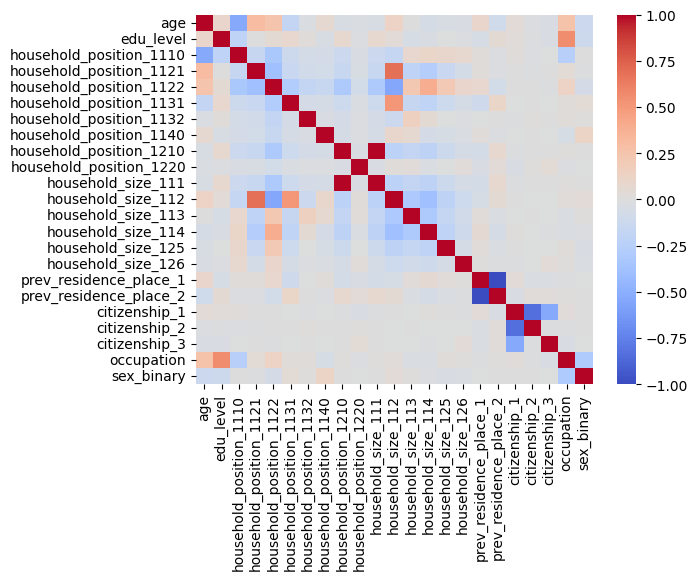

In [ ]:
fs1 = ['age','edu_level','household_position','household_size','prev_residence_place','citizenship']
dummy_cols = ['household_position','household_size','prev_residence_place','citizenship']

dutch_data_fs1 = pd.DataFrame(dutch_data[fs1])
dutch_data_fs1 = pd.get_dummies(dutch_data_fs1,columns=dummy_cols)
dutch_data_fs1['occupation'] = dutch_data.occupation
dutch_data_fs1['sex_binary'] = dutch_data.sex_binary
dutch_corr = dutch_data_fs1.corr()
sns.heatmap(dutch_corr,cmap="coolwarm",vmin=-1,vmax=1)
plt.show()

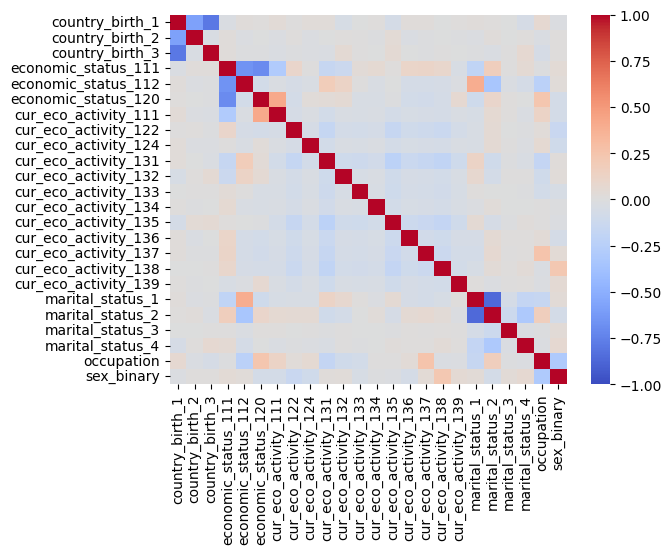

In [ ]:
fs2 = ['country_birth','economic_status','cur_eco_activity','marital_status']
dummy_cols = ['country_birth','economic_status','cur_eco_activity','marital_status']

dutch_data_fs2 = pd.DataFrame(dutch_data[fs2])
dutch_data_fs2 = pd.get_dummies(dutch_data_fs2,columns=dummy_cols)
dutch_data_fs2['occupation'] = dutch_data.occupation
dutch_data_fs2['sex_binary'] = dutch_data.sex_binary
dutch_corr2 = dutch_data_fs2.corr()
sns.heatmap(dutch_corr2,cmap="coolwarm",vmin=-1,vmax=1)
plt.show()

In [ ]:
def label_encode(df,columns_to_encode):

  for i in columns_to_encode:
    tmp = df[i].iloc[0]
    
    if type(tmp) != int or type(tmp) != float:
      le = preprocessing.LabelEncoder()
      df[i] = le.fit_transform(df[i].values)

  return df

In [ ]:
sensitive = ['sex_binary']
target = ['occupation']
dutch_to_keep = ['age','edu_level']
dutch_to_oh = ['household_position','household_size','prev_residence_place','citizenship','country_birth','economic_status','cur_eco_activity','marital_status']

In [ ]:
dutch_data_le = dutch_data.copy()
dutch_data_le = label_encode(dutch_data_le,dutch_to_oh)

<ipython-input-75-90897b9a2f31>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dutch_corr2 = dutch_data_le.corr()


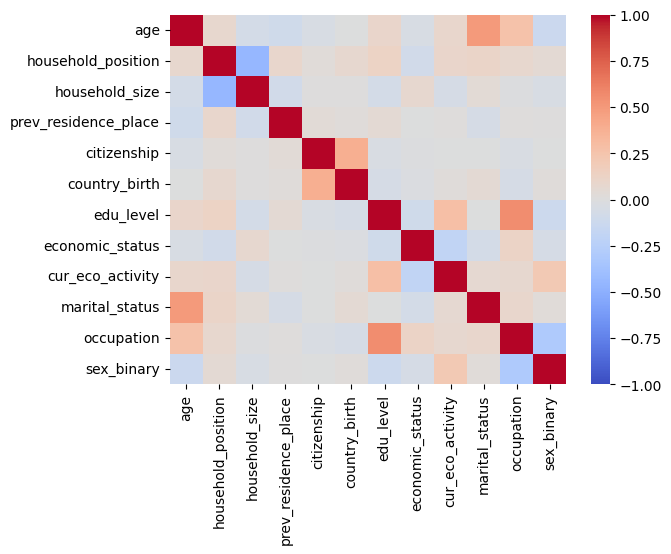

In [ ]:

dutch_corr2 = dutch_data_le.corr()
sns.heatmap(dutch_corr2,cmap="coolwarm",vmin=-1,vmax=1)
plt.show()

### 3.3 DPR and EO Metrics

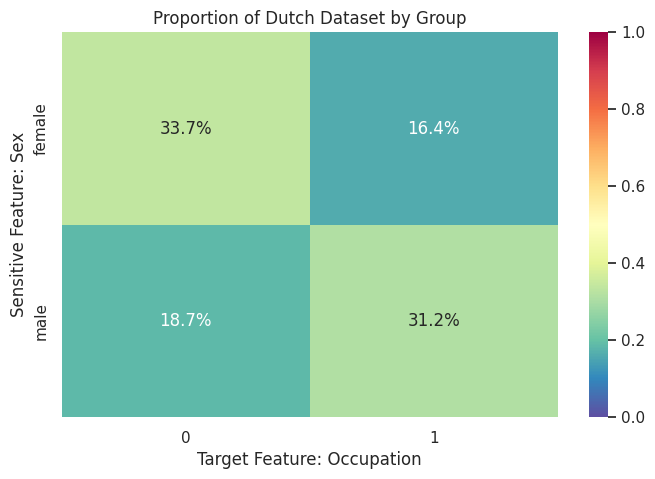

In [ ]:
dutch_cm_df = dutch_data.groupby(['sex','occupation']).count()['age']
dutch_cm_df = pd.DataFrame(dutch_cm_df).reset_index()
dutch_cm_df = dutch_cm_df.pivot(index='sex',columns='occupation',values='age')

dutch_cm_df = dutch_cm_df / dutch_cm_df.sum().sum()
dutch_cm_df = dutch_cm_df.round(3)

sns.set(rc={'figure.figsize':(8,5)})
sns.heatmap(dutch_cm_df,vmin=0,vmax=1,annot=True,fmt=".1%",cmap="Spectral_r")
plt.xlabel("Target Feature: Occupation")
plt.ylabel("Sensitive Feature: Sex")
plt.title("Proportion of Dutch Dataset by Group")

plt.show()

In [ ]:
dutch_dpd = dpd(dutch_data.occupation, dutch_data.occupation, dutch_data.sex_binary)
dutch_dpd.round(3)

0.298